# *Final Project*

This project aims to develop a machine learning-based IDS that can accurately classify network traffic as benign or malicious, addressing issues like scalability, class imbalance, and detection of rare attack scenarios.

## 1. Importing required libraries

In [1]:
# Importing required libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import logging
import seaborn as sns
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter

## 2. Creating a logger to generate logs for the entire code

In [2]:
# Configure the logging
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Create a logger
logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")

## 3. Get details of different files in the dataset

In [3]:
start_time = datetime.datetime.now()
def load_and_check_csv_files(folder_path):
    """
    Loads multiple CSV files from a folder, checks the number of rows and columns in each,
    and verifies if all files have the same columns.

    Parameters:
    - folder_path (str): Path to the folder containing the CSV files.

    Returns:
    - summary (pd.DataFrame): Summary of rows and columns in each file.
    - columns_match (bool): Whether all files have identical columns.
    - differing_columns (dict): Files with columns that differ from the majority.
    """
    file_summaries = []
    all_columns = {}
    
    # Iterate through all files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            try:
                # Load the CSV file
                df = pd.read_csv(file_path)
                file_summaries.append({
                    "File Name": file_name,
                    "Rows": df.shape[0],
                    "Columns": df.shape[1]
                })
                # Store columns for comparison
                all_columns[file_name] = set(df.columns)
            except Exception as e:
                print(f"Error reading {file_name}: {e}")
    
    # Create a summary DataFrame
    summary = pd.DataFrame(file_summaries)
    
    # Check if all files have the same columns
    common_columns = all_columns[list(all_columns.keys())[0]]
    differing_columns = {
        file: cols for file, cols in all_columns.items() if cols != common_columns
    }
    columns_match = len(differing_columns) == 0
    
    return summary, columns_match, differing_columns

# Example usage
# Replace 'folder_path' with the path to the folder containing your CSV files
folder_path = 'archive_test'
summary, columns_match, differing_columns = load_and_check_csv_files(folder_path)

# Display the summary
print(summary)

if columns_match:
    print("All files have identical columns.")
else:
    print("The following files have differing columns:")
    for file, cols in differing_columns.items():
        print(f"{file}: {cols}")

stop_time = datetime.datetime.now()
logger.info(f"Time taken to process the block: {stop_time - start_time}")

2024-12-11 22:58:44 - INFO - Time taken to process the block: 0:00:02.438423


                                          File Name    Rows  Columns
0  Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv  225745       79
All files have identical columns.


## 4. Load the dataset

This code loads multiple CSV files from a specified folder, combines them into a single DataFrame, and logs the process details. It iterates through the folder, identifies files with a `.csv` extension, and loads each file into a DataFrame. These DataFrames are then merged into one using `pd.concat()`, and the combined dataset's shape is logged for reference. The script also calculates and logs the time taken for the entire operation, providing both performance insights and a streamlined data loading process.

In [4]:
start_time = datetime.datetime.now()
# Step 1: Load the dataset and overview of initial data
folder_path = "archive_test"
dataframes = []
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        logger.info(f"Loading file: {file_path}")
        df = pd.read_csv(file_path)
        dataframes.append(df)

# Combine all datasets into a single DataFrame
data = pd.concat(dataframes, ignore_index=True)
initial_shape = data.shape
logger.info(f"Step 1: Combined Dataset Shape: {data.shape}")
stop_time = datetime.datetime.now()
logger.info(f"Time taken to process the block: {stop_time - start_time}")

2024-12-11 22:58:44 - INFO - Loading file: archive_test\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
2024-12-11 22:58:47 - INFO - Step 1: Combined Dataset Shape: (225745, 79)
2024-12-11 22:58:47 - INFO - Time taken to process the block: 0:00:02.869134


## 5. Cleaning column names

This code removes any extra spaces from the beginning and end of the column names in the dataset to make them clean and consistent. It logs the shape of the dataset, noting that no rows or columns are affected during this process. The script also calculates and logs the time taken for this operation to track its performance.

In [5]:
start_time = datetime.datetime.now()
# Step 2: Clean column names
data.columns = data.columns.str.strip()
logger.info(f"Step 2: Dataset Shape after cleaning column names: {data.shape} (No rows/columns affected)")
stop_time = datetime.datetime.now()
logger.info(f"Time taken to process the block: {stop_time - start_time}")

2024-12-11 22:58:47 - INFO - Step 2: Dataset Shape after cleaning column names: (225745, 79) (No rows/columns affected)
2024-12-11 22:58:47 - INFO - Time taken to process the block: 0:00:00.015627


## 6. Handle duplicates

This code removes duplicate rows from the dataset using the `drop_duplicates()` function, ensuring the data is unique and accurate. It calculates the number of rows removed by comparing the dataset's size before and after the operation. The updated dataset shape and the count of removed rows are logged. Additionally, the time taken for this operation is measured and logged for performance tracking.

In [6]:
start_time = datetime.datetime.now()
# Step 3: Handle duplicates
before_duplicates = data.shape[0]
data = data.drop_duplicates()
rows_removed = before_duplicates - data.shape[0]
logger.info(f"Step 3: Dataset Shape after removing duplicates: {data.shape} ({rows_removed} rows removed)")
stop_time = datetime.datetime.now()
logger.info(f"Time taken to process the block: {stop_time - start_time}")

2024-12-11 22:58:49 - INFO - Step 3: Dataset Shape after removing duplicates: (223112, 79) (2633 rows removed)
2024-12-11 22:58:49 - INFO - Time taken to process the block: 0:00:01.925647


## 7. Check and handle missing values

This code identifies and handles missing values in the dataset. It first checks for missing values in all columns using `isnull().sum()` and prints the count of missing values for columns that have them. For numeric columns (identified using `select_dtypes()`), it fills the missing values with the median of each column using the `fillna()` function. The dataset shape is logged after handling missing values, noting that no rows are removed, and the number of columns with missing values is recorded. Additionally, the time taken for this operation is measured and logged for performance tracking.

In [7]:
start_time = datetime.datetime.now()
# Step 4: Check and handle missing values
missing_values = data.isnull().sum()
print("Step 4: Missing Values:\n", missing_values[missing_values > 0])

before_missing = data.shape[0]
# Fill missing values with median for numeric columns only
numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())
rows_filled_missing = before_missing - data.shape[0]
print(f"Step 4: Dataset Shape after handling missing values: {data.shape} (No rows removed, {len(missing_values[missing_values > 0])} columns filled)")
stop_time = datetime.datetime.now()
logger.info(f"Time taken to process the block: {stop_time - start_time}")

Step 4: Missing Values:
 Flow Bytes/s    4
dtype: int64


2024-12-11 22:58:50 - INFO - Time taken to process the block: 0:00:00.946813


Step 4: Dataset Shape after handling missing values: (223112, 79) (No rows removed, 1 columns filled)


## 8. Handle `inf` values

This code handles infinite (`inf` and `-inf`) and large values in the dataset. It replaces `inf` and `-inf` with `NaN` using the `replace()` function. For numeric columns, these `NaN` values are then filled with the maximum value of each respective column using `fillna()`. The dataset shape is logged after handling these values, noting that no rows are removed and the infinite values have been addressed. Additionally, the time taken for this operation is measured and logged for performance tracking.

In [8]:
start_time = datetime.datetime.now()
# Step 5: Handle `inf` and large values
before_inf = data.shape[0]
# Replace inf and -inf with NaN, then fill them with column max
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].max())
rows_filled_inf = before_inf - data.shape[0]
logger.info(f"Step 5: Dataset Shape after handling `inf` values: {data.shape} (No rows removed, inf values handled)")
stop_time = datetime.datetime.now()
logger.info(f"Time taken to process the block: {stop_time - start_time}")

2024-12-11 22:58:51 - INFO - Step 5: Dataset Shape after handling `inf` values: (223112, 79) (No rows removed, inf values handled)
2024-12-11 22:58:51 - INFO - Time taken to process the block: 0:00:00.882852


## 9. Remove constant features

This code identifies and removes constant features from the dataset. Constant features are columns in which all values are the same, detected by checking if a column has only one unique value using `nunique()`. The names of these constant columns are logged, and they are removed using the `drop()` function. The updated dataset shape is logged, including the number of columns removed. Additionally, the time taken for this operation is measured and logged for performance tracking.

In [9]:
start_time = datetime.datetime.now()
# Step 6: Remove constant features
constant_columns = [col for col in numeric_columns if data[col].nunique() == 1]
columns_removed = len(constant_columns)
logger.info(f"Step 6: Constant Features to Remove: {constant_columns}")
data = data.drop(columns=constant_columns)
logger.info(f"Step 6: Dataset Shape after removing constant features: {data.shape} ({columns_removed} columns removed)")
stop_time = datetime.datetime.now()
logger.info(f"Time taken to process the block: {stop_time - start_time}")

2024-12-11 22:58:51 - INFO - Step 6: Constant Features to Remove: ['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'CWE Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
2024-12-11 22:58:51 - INFO - Step 6: Dataset Shape after removing constant features: (223112, 69) (10 columns removed)
2024-12-11 22:58:51 - INFO - Time taken to process the block: 0:00:00.863595


## 10. Correlation Analysis

This code analyzes feature correlations in the dataset, focusing on the 'Label' column, to aid in feature selection and dimensionality reduction. It starts by identifying the unique values in the 'Label' column and mapping them to numeric values, which are stored in a new column called `Label_numeric`. The list of numeric columns is updated to include this new column, and a correlation matrix is calculated for all numeric features. This correlation matrix is visualized as a heatmap to show the relationships between features. Next, features with a correlation greater than 0.3 with `Label_numeric` are selected, and the dataset is filtered to include only these features. The original and filtered correlation matrices are saved as CSV files for reference, and the filtered correlation matrix is visualized in another heatmap.

The code then identifies features highly correlated with each other (correlation > 0.8) in the filtered dataset, logging these for potential dimensionality reduction. It also compares the highly correlated features with the selected features to identify overlapping and unique columns. This entire process, including the time taken for execution, is logged. The workflow helps reduce multicollinearity and focuses on key features relevant to the target variable, streamlining the dataset for improved model performance.

Unique values in 'Label': ['BENIGN' 'DDoS']
Label Mapping: {'BENIGN': 0, 'DDoS': 1}
Updated Numeric Columns: Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Leng

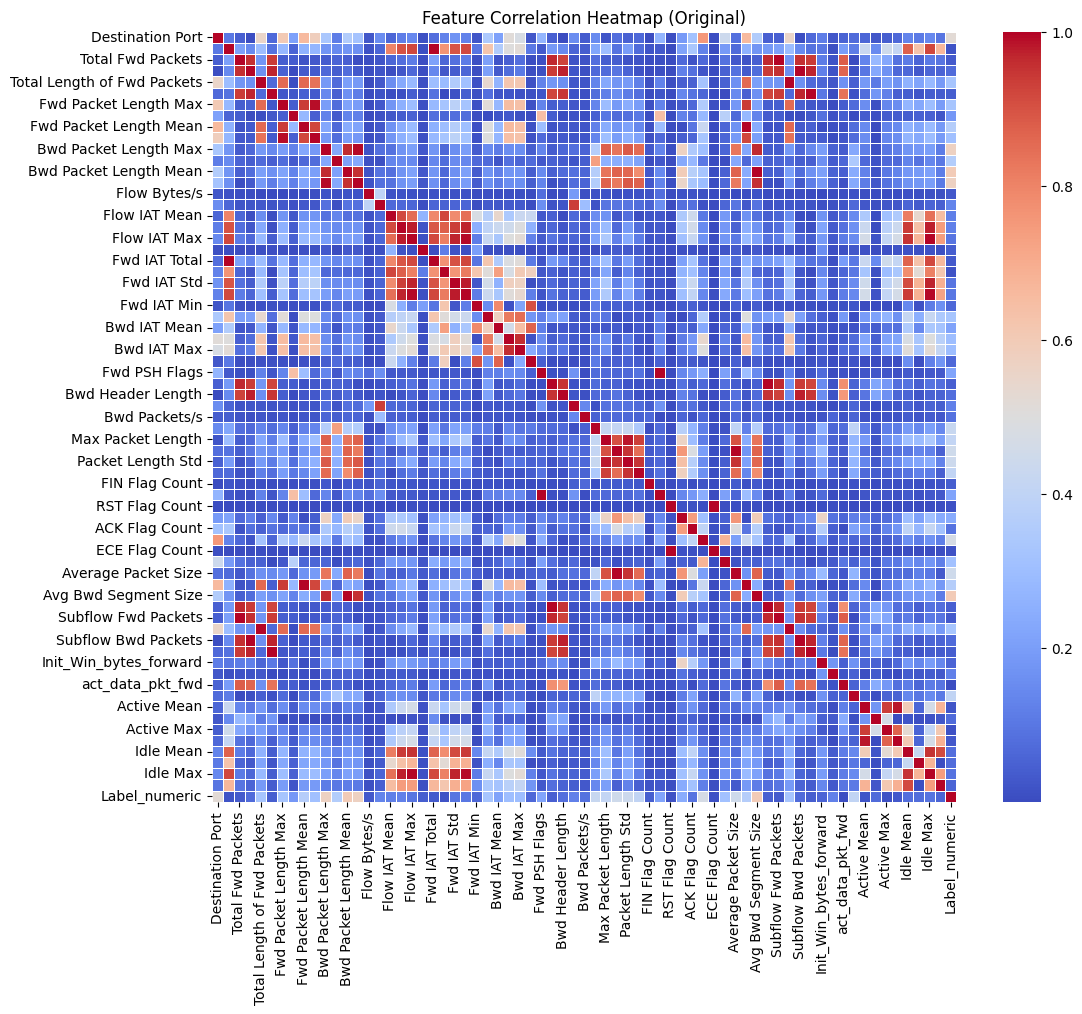

Selected Features with Correlation > 0.3: ['Destination Port', 'Total Length of Fwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Bwd IAT Total', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'URG Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Bytes', 'min_seg_size_forward', 'Label_numeric']


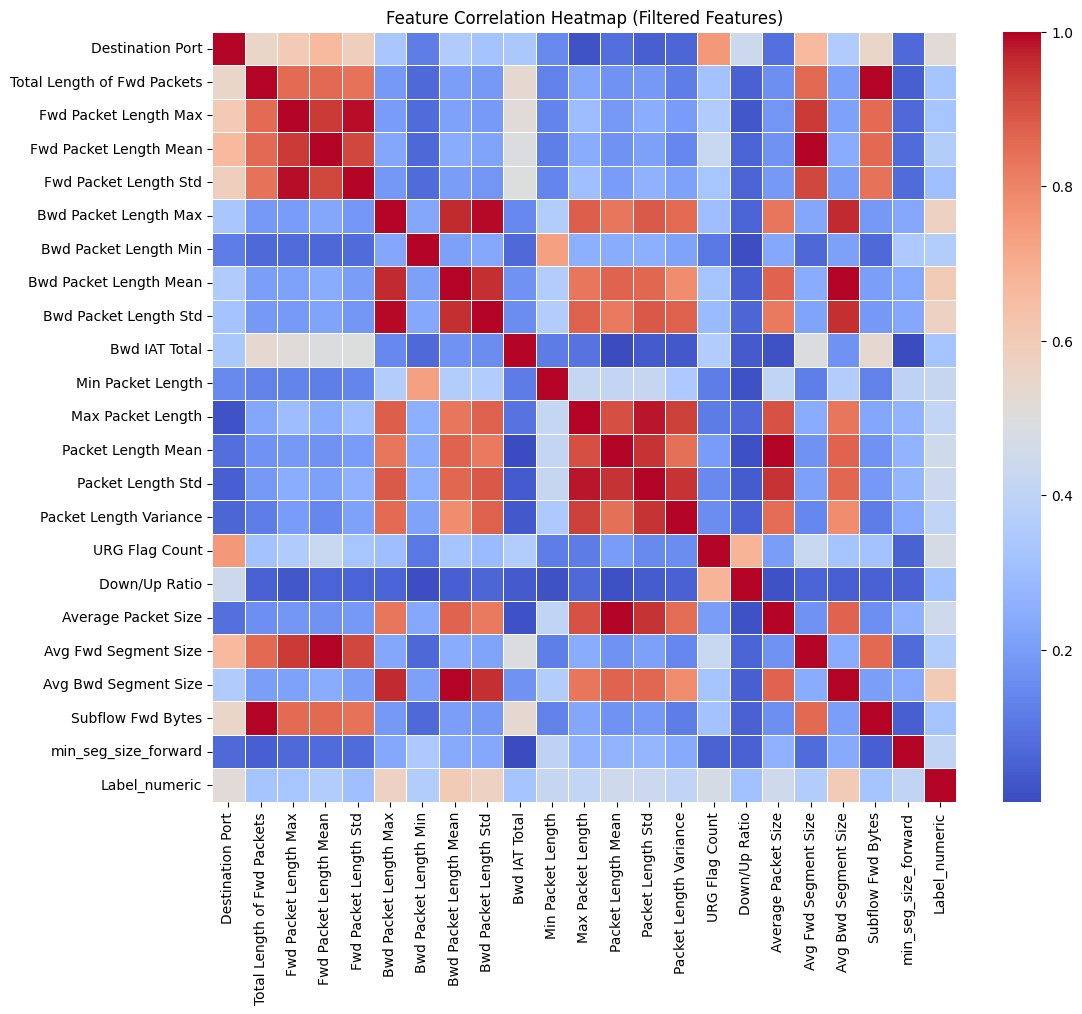

2024-12-11 22:59:01 - INFO - Highly Correlated Features for Dimensionality Reduction: ['Total Length of Fwd Packets', 'Fwd Packet Length Std', 'Packet Length Std', 'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Packet Length Mean', 'Bwd Packet Length Mean', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Bytes', 'Packet Length Variance', 'Max Packet Length', 'Bwd Packet Length Max', 'Average Packet Size', 'Bwd Packet Length Std']
2024-12-11 22:59:01 - INFO - Time taken to process the block: 0:00:09.774581


Similar Columns: {'Total Length of Fwd Packets', 'Fwd Packet Length Std', 'Packet Length Std', 'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Packet Length Mean', 'Bwd Packet Length Mean', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Bytes', 'Packet Length Variance', 'Max Packet Length', 'Bwd Packet Length Max', 'Average Packet Size', 'Bwd Packet Length Std'}
Different Columns: {'Down/Up Ratio', 'URG Flag Count', 'Bwd IAT Total', 'Min Packet Length', 'Destination Port', 'Bwd Packet Length Min', 'Label_numeric', 'min_seg_size_forward'}


In [10]:
start_time = datetime.datetime.now()

# Step 1: Check unique values in 'Label' column
unique_labels = data['Label'].unique()
print("Unique values in 'Label':", unique_labels)

# Step 2: Create a mapping for the categorical 'Label' values
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
print("Label Mapping:", label_mapping)

# Step 3: Map the 'Label' column to numerical values and store in a new column
data['Label_numeric'] = data['Label'].map(label_mapping)

# Step 4: Recalculate the numeric columns to include the new 'Label_numeric' column
numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
print("Updated Numeric Columns:", numeric_columns)

# Step 5: Calculate the correlation matrix with the new column
correlation_matrix = data[numeric_columns].corr().abs()

# Step 6: Display the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap (Original)")
plt.show()

# Step 7: Filter features with correlation > 0.3 with 'Label_numeric'
correlations_with_label = correlation_matrix['Label_numeric']
selected_features = correlations_with_label[correlations_with_label > 0.3].index.tolist() # Change back to 0.3
print("Selected Features with Correlation > 0.3:", selected_features)

# Step 8: Subset the dataset to keep only selected features
filtered_data = data[selected_features]

# Step 9: Save both original and filtered correlation matrices to CSV files
correlation_matrix.to_csv('original_correlation_matrix.csv', index=True)
filtered_correlation_matrix = filtered_data.corr().abs()
filtered_correlation_matrix.to_csv('filtered_correlation_matrix.csv', index=True)

# Step 10: Display the filtered correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap (Filtered Features)")
plt.show()

# Step 11: Get upper triangle of the filtered correlation matrix
upper_triangle = filtered_correlation_matrix.where(
    np.triu(np.ones(filtered_correlation_matrix.shape), k=1).astype(bool)
)

# Step 12: Identify features highly correlated with each other (e.g., correlation > 0.8)
highly_correlated = set()
for column in upper_triangle.columns:
    correlated_columns = upper_triangle.index[upper_triangle[column] > 0.8].tolist()
    if correlated_columns:  # If there are any correlations > 0.8
        highly_correlated.update(correlated_columns + [column])

# Convert to list for logging and further processing
highly_correlated = list(highly_correlated)
logger.info(f"Highly Correlated Features for Dimensionality Reduction: {highly_correlated}")

# Convert the columns of filtered_data to a set
filtered_data_columns = set(filtered_data.columns)

# Convert highly_correlated to a set
highly_correlated_set = set(highly_correlated)

# Find similar columns (intersection)
similar_columns = filtered_data_columns.intersection(highly_correlated_set)

# Find different columns (difference)
different_columns = filtered_data_columns.difference(highly_correlated_set)

# Output the results
print("Similar Columns:", similar_columns)
print("Different Columns:", different_columns)

stop_time = datetime.datetime.now()
logger.info(f"Time taken to process the block: {stop_time - start_time}")

## Outlier Detection and Removal

This code focuses on preparing the dataset by selecting relevant features, separating the target variable, and detecting outliers using three different methods. First, it updates the list of selected features by removing the `Label_numeric` column (if it exists) and adding the `Label` column. The dataset is then subset to include only the selected features present in the data, separating the `Label` column as the target variable while keeping the rest for outlier detection.

The outlier detection process is carried out using three methods: Local Outlier Factor (LOF), Isolation Forest, and Robust Covariance (Elliptic Envelope). Each method identifies data points as either outliers (-1) or inliers (1), and the predictions are stored as separate columns in the dataset. The dataset is then filtered to retain only the rows classified as inliers by all three methods, ensuring a clean and reliable dataset. Temporary columns used for outlier labels are dropped, and the `Label` column is reattached to the filtered data.

Finally, the filtered dataset's row count and a sample of the data are displayed, providing a clear view of the cleaned data. The time taken to execute the entire process is measured and logged for performance tracking.

In [11]:
# Start time to track execution duration
start_time = datetime.datetime.now()

# Column to remove
column_to_remove = 'Label_numeric'

# Column to add
column_to_add = 'Label'

# Remove the column if it exists in the list
if column_to_remove in selected_features:
    selected_features.remove(column_to_remove)

# Add the new column
selected_features.append(column_to_add)

print("Updated selected_features:", selected_features)

# Ensure selected_features exists in the data columns
selected_features_in_data = [col for col in selected_features if col in data.columns]

# Subset the dataframe and reassign it to the same variable
data = data[selected_features_in_data]

# Step 0: Separate the target variable 'Label' from the features
label_column = data["Label"]  # Save the target column
data_without_label = data.drop(columns=["Label"])  # Drop the target column for outlier detection

# -----------------------------------------------------------------------------
# Step 1: Fit the Local Outlier Factor (LOF) model
# -----------------------------------------------------------------------------
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
# Predict the labels for each data point as either outlier (-1) or inlier (1)
y_pred_lof = lof.fit_predict(data_without_label)

# Display the type of 'y_pred_lof' and frequency of each label
print("LOF Prediction Type:", type(y_pred_lof))
print("LOF Outlier/Inlier Counts:", np.unique(y_pred_lof, return_counts=True))


# -----------------------------------------------------------------------------
# Step 2: Fit the Isolation Forest model
# -----------------------------------------------------------------------------
iforest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
# Predict the labels for each data point as either outlier (-1) or inlier (1)
y_pred_if = iforest.fit_predict(data_without_label)

# Display the type of 'y_pred_if' and frequency of each label
print("Isolation Forest Prediction Type:", type(y_pred_if))
print("Isolation Forest Outlier/Inlier Counts:", np.unique(y_pred_if, return_counts=True))


# -----------------------------------------------------------------------------
# Step 3: Fit the robust covariance model (Elliptic Envelope)
# -----------------------------------------------------------------------------
rob_cov = EllipticEnvelope(contamination=0.05, random_state=42)
# Fit the model and predict labels for each data point as either outlier (-1) or inlier (1)
rob_cov.fit(data_without_label)
y_pred_rob = rob_cov.predict(data_without_label)

# Display the type of 'y_pred_rob' and frequency of each label
print("Robust Covariance Prediction Type:", type(y_pred_rob))
print("Robust Covariance Outlier/Inlier Counts:", np.unique(y_pred_rob, return_counts=True))


# -----------------------------------------------------------------------------
# Add the newly predicted labels to the data_without_label DataFrame
# -----------------------------------------------------------------------------
data_without_label["y_pred_lof"] = y_pred_lof
data_without_label["y_pred_if"] = y_pred_if
data_without_label["y_pred_rob"] = y_pred_rob

# -----------------------------------------------------------------------------
# Filter the data to keep only rows identified as inliers (label = 1) by all three methods
# -----------------------------------------------------------------------------
filtered_data = data_without_label[
    (data_without_label["y_pred_lof"] == 1) & 
    (data_without_label["y_pred_if"] == 1) & 
    (data_without_label["y_pred_rob"] == 1)
]

# Drop temporary outlier columns
filtered_data = filtered_data.drop(columns=["y_pred_lof", "y_pred_if", "y_pred_rob"])

# Reattach the target column 'Label' to the filtered dataframe
filtered_data["Label"] = label_column.loc[filtered_data.index]

# -----------------------------------------------------------------------------
# Display the resulting filtered data and row counts
# -----------------------------------------------------------------------------
print("Original Data Row Count:", data.shape[0])
print("Filtered Data Row Count:", filtered_data.shape[0])
print("Filtered Data Sample:")
print(filtered_data.head())

data = filtered_data

stop_time = datetime.datetime.now()
logger.info(f"Time taken to process the block: {stop_time - start_time}")

Updated selected_features: ['Destination Port', 'Total Length of Fwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Bwd IAT Total', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'URG Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Bytes', 'min_seg_size_forward', 'Label']
LOF Prediction Type: <class 'numpy.ndarray'>
LOF Outlier/Inlier Counts: (array([-1,  1]), array([ 11156, 211956], dtype=int64))
Isolation Forest Prediction Type: <class 'numpy.ndarray'>
Isolation Forest Outlier/Inlier Counts: (array([-1,  1]), array([ 11146, 211966], dtype=int64))


2024-12-11 23:03:04 - INFO - Time taken to process the block: 0:04:02.502298


Robust Covariance Prediction Type: <class 'numpy.ndarray'>
Robust Covariance Outlier/Inlier Counts: (array([-1,  1]), array([ 11156, 211956], dtype=int64))
Original Data Row Count: 223112
Filtered Data Row Count: 198569
Filtered Data Sample:
   Destination Port  Total Length of Fwd Packets  Fwd Packet Length Max  \
0             54865                           12                      6   
1             55054                            6                      6   
2             55055                            6                      6   
3             46236                            6                      6   
4             54863                           12                      6   

   Fwd Packet Length Mean  Fwd Packet Length Std  Bwd Packet Length Max  \
0                     6.0                    0.0                      0   
1                     6.0                    0.0                      6   
2                     6.0                    0.0                      6   
3      

## 11. Final dataset shape before training and testing

This code provides a summary of the dataset's final shape after all preprocessing steps. It calculates the total number of rows and columns removed by comparing the dataset's initial shape to its final shape. The final dimensions of the dataset, along with the counts of removed rows and columns, are logged for reference. The time taken to execute this block is also measured and logged, providing insights into the overall efficiency of the preprocessing process.

In [12]:
start_time = datetime.datetime.now()

# Final dataset shape
final_shape = data.shape
rows_removed_total = initial_shape[0] - final_shape[0]
columns_removed_total = initial_shape[1] - final_shape[1]
logger.info(f"Step 10: Final Dataset Shape: {data.shape}")
logger.info(f"Summary: {rows_removed_total} rows and {columns_removed_total} columns removed in total.")
stop_time = datetime.datetime.now()
logger.info(f"Time taken to process the block: {stop_time - start_time}")

2024-12-11 23:03:04 - INFO - Step 10: Final Dataset Shape: (198569, 23)
2024-12-11 23:03:04 - INFO - Summary: 27176 rows and 56 columns removed in total.
2024-12-11 23:03:04 - INFO - Time taken to process the block: 0:00:00.001551


## 12. Standardizing the numerical values

This code normalizes the numerical features in the dataset to ensure they are on a similar scale, which is important for many machine learning algorithms. It identifies the numeric columns in the dataset and uses the `StandardScaler` to standardize their values by removing the mean and scaling to unit variance. The dataset's shape is logged after normalization, confirming that no rows or columns were removed during this process. Additionally, the time taken to execute this step is measured and logged for performance tracking.

In [13]:
start_time = datetime.datetime.now()
# Normalize numerical features
# Recompute numeric columns after correlation analysis
numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
logger.info(f"Step 8: Dataset Shape after normalizing numerical features: {data.shape} (No rows/columns removed)")
stop_time = datetime.datetime.now()
logger.info(f"Time taken to process the block: {stop_time - start_time}")

2024-12-11 23:03:04 - INFO - Step 8: Dataset Shape after normalizing numerical features: (198569, 23) (No rows/columns removed)
2024-12-11 23:03:04 - INFO - Time taken to process the block: 0:00:00.345273


## PCA - Dimension Reduction

This code performs Principal Component Analysis (PCA) to reduce the dimensionality of the dataset while retaining most of the variance. It begins by separating the features and target variable (`Label`). Initially, PCA is performed on all features to analyze the explained variance for each principal component. The cumulative variance is calculated to determine the number of components required to retain at least 95% of the variance.

Once the optimal number of components is identified, PCA is re-applied to reduce the dataset to this number of components. The reduced components are then stored in a new DataFrame with appropriately named columns (e.g., `PC1`, `PC2`, etc.), and the target variable is reattached. The resulting DataFrame with reduced dimensions is displayed, and the time taken to execute the process is logged for performance analysis. This approach ensures the dataset is simplified while preserving its essential information for further analysis or modeling.

In [14]:
start_time = datetime.datetime.now()
# Step 1: Separate features and target
features = data.drop(columns=['Label'])  # Drop the 'Label' column to keep only features
target = data['Label']  # Save the target column

# Step 2: Perform PCA
pca = PCA()  # Keep all components initially to analyze explained variance
pca_components = pca.fit_transform(features)

# Step 3: Analyze explained variance to decide number of components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()
print("Explained Variance Ratio:", explained_variance_ratio)
print("Cumulative Variance:", cumulative_variance)

# Step 4: Choose the number of components (e.g., 95% of variance)
n_components = next(i for i, total_var in enumerate(cumulative_variance) if total_var >= 0.95) + 1
print(f"Number of components to retain: {n_components}")

# Step 5: Perform PCA with the chosen number of components
pca = PCA(n_components=n_components)
reduced_components = pca.fit_transform(features)

# Step 6: Create a dataframe for the reduced components and merge with the target
pca_columns = [f"PC{i+1}" for i in range(n_components)]
reduced_data = pd.DataFrame(reduced_components, columns=pca_columns)
reduced_data['Label'] = target.reset_index(drop=True)  # Add the target column back

# Step 7: Resulting dataframe
print("Data after PCA:")
print(reduced_data.head())

stop_time = datetime.datetime.now()
logger.info(f"Time taken to process the block: {stop_time - start_time}")

2024-12-11 23:03:05 - INFO - Time taken to process the block: 0:00:00.233853


Explained Variance Ratio: [4.17698360e-01 2.62773094e-01 1.02392900e-01 7.16197226e-02
 3.78195303e-02 3.22791590e-02 2.28680226e-02 1.64318752e-02
 1.21803445e-02 9.92715761e-03 6.05721320e-03 3.62631644e-03
 2.23998348e-03 9.83140570e-04 9.10332833e-04 1.40269875e-04
 3.62303419e-05 1.14472207e-05 4.90117987e-06 6.73872969e-18
 0.00000000e+00 0.00000000e+00]
Cumulative Variance: [0.41769836 0.68047145 0.78286435 0.85448408 0.89230361 0.92458277
 0.94745079 0.96388266 0.97606301 0.98599016 0.99204738 0.99567369
 0.99791368 0.99889682 0.99980715 0.99994742 0.99998365 0.9999951
 1.         1.         1.         1.        ]
Number of components to retain: 8
Data after PCA:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -2.415410 -0.557593  1.070546 -0.838554 -0.091822  0.117304 -1.166798   
1 -2.829314 -0.011173  2.955772 -0.063348  0.368341 -0.045769 -1.560183   
2 -2.829321 -0.011163  2.955799 -0.063341  0.368348 -0.045767 -1.560205   
3 -2.763503 -0.09896

## Train-Validation-Test Split

This code prepares the dataset for training by encoding the target variable, splitting the data into training, validation, and testing sets, and addressing class imbalance. It starts by separating the `Label` column from the features and encoding it using `LabelEncoder` to convert categorical values into numeric form. The dataset is then split into training, validation, and test sets using `train_test_split`, ensuring a 40% split for the temporary validation and test sets, which are further divided equally.

To handle class imbalance in the training set, the code applies SMOTE (Synthetic Minority Oversampling Technique), which generates synthetic samples for the minority class to balance the dataset. The shapes of the balanced training set and the unbalanced validation and testing sets are printed for verification. Finally, the time taken to complete the process is logged to monitor performance. This workflow ensures the data is ready for model training, with balanced classes in the training set for better learning.

In [15]:
start_time = datetime.datetime.now()

# Step 1: Exclude 'Label' column and encode it
label_column = reduced_data['Label']
reduced_data = reduced_data.drop(columns=['Label'])

label_encoder = LabelEncoder()
label_column_encoded = label_encoder.fit_transform(label_column)

# Step 2: Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(
    reduced_data, label_column_encoded, test_size=0.4, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Class Distribution in Training Set:", Counter(y_train))

# Step 3: Handle class imbalance with SMOTE
smote = SMOTE(random_state=42, k_neighbors=2) # Remove k_neighbors in SMOTE
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Print dataset shapes
print("Training Data Shape:", X_train_balanced.shape)
print("Validation Data Shape:", X_val.shape)
print("Testing Data Shape:", X_test.shape)

stop_time = datetime.datetime.now()
logger.info(f"Time taken to process the block: {stop_time - start_time}")

Class Distribution in Training Set: Counter({1: 75180, 0: 43961})


2024-12-11 23:03:06 - INFO - Time taken to process the block: 0:00:01.012499


Training Data Shape: (150360, 8)
Validation Data Shape: (39714, 8)
Testing Data Shape: (39714, 8)


## Logistic Regression Model

This code trains and evaluates a Logistic Regression model with hyperparameter tuning using Grid Search. First, the Logistic Regression model is initialized with a solver (`lbfgs`) and a maximum number of iterations set to 1000. A grid of hyperparameters is defined, including different values for the regularization strength (`C`) and the penalty type (`l2`).

Grid Search with 3-fold cross-validation is performed using `GridSearchCV` to find the best combination of hyperparameters. The model is trained on the balanced training set, and the best model is selected based on the accuracy score. The selected model is then evaluated on the validation set, and metrics such as accuracy, F1 score, and a detailed classification report are calculated and printed. The total time taken for this process is logged to track execution performance. This workflow ensures the model is optimized for better predictive performance.

In [16]:
start_time = datetime.datetime.now()

# Step 1: Initialize the model
logistic_model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)

# Step 2: Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2']
}

# Step 3: Perform Grid Search for hyperparameter tuning
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_balanced, y_train_balanced)

# Step 4: Evaluate the model
best_logistic_model = grid_search.best_estimator_
y_val_pred = best_logistic_model.predict(X_val)

print("Logistic Regression Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Logistic Regression F1 Score:", f1_score(y_val, y_val_pred, average='weighted'))
print("Classification Report:\n", classification_report(y_val, y_val_pred))

stop_time = datetime.datetime.now()
logger.info(f"Time taken to process the block: {stop_time - start_time}")

2024-12-11 23:03:13 - INFO - Time taken to process the block: 0:00:07.736974


Logistic Regression Validation Accuracy: 0.9837085158886035
Logistic Regression F1 Score: 0.9836323418856162
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     14731
           1       0.98      1.00      0.99     24983

    accuracy                           0.98     39714
   macro avg       0.99      0.98      0.98     39714
weighted avg       0.98      0.98      0.98     39714



### Summary:
The results show that the Logistic Regression model performs exceptionally well, achieving an accuracy of 98% on the validation dataset. The F1 score, which balances precision and recall, is also 98.36%, indicating consistent performance across all classes. The classification report reveals high precision and recall for both classes, with class `0` having a precision of 100% and recall of 96%, and class `1` achieving 98% precision and 100% recall. These metrics demonstrate that the model is highly effective at predicting both classes, making it a reliable choice for this dataset (2-class problem).

## Random Forest Model

This code trains and evaluates a Random Forest Classifier, including hyperparameter tuning using Randomized Search. First, the Random Forest model is initialized with a specified random state and configured to utilize multiple CPU cores (`n_jobs=-1`) for faster processing. A hyperparameter grid is defined, including potential values for the number of estimators (`n_estimators`), maximum tree depth (`max_depth`), minimum samples required to split a node (`min_samples_split`), and minimum samples required for a leaf node (`min_samples_leaf`).

Randomized Search with 3-fold cross-validation is performed using `RandomizedSearchCV` to explore 50 different combinations of hyperparameters randomly. The best model is selected based on cross-validation results, and this optimized model is used to make predictions on the validation set. The validation accuracy, F1 score, and a detailed classification report are calculated and printed to assess the model's performance. Finally, the total time taken for this entire process is logged to track execution efficiency. This workflow ensures the Random Forest model is finely tuned for optimal performance.

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Best Score: 0.9995477520617185
Random Forest Validation Accuracy: 0.9995215792919373
Random Forest F1 Score: 0.9995216225428698
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     14731
           1       1.00      1.00      1.00     24983

    accuracy                           1.00     39714
   macro avg       1.00      1.00      1.00     39714
weighted avg       1.00      1.00      1.00     39714



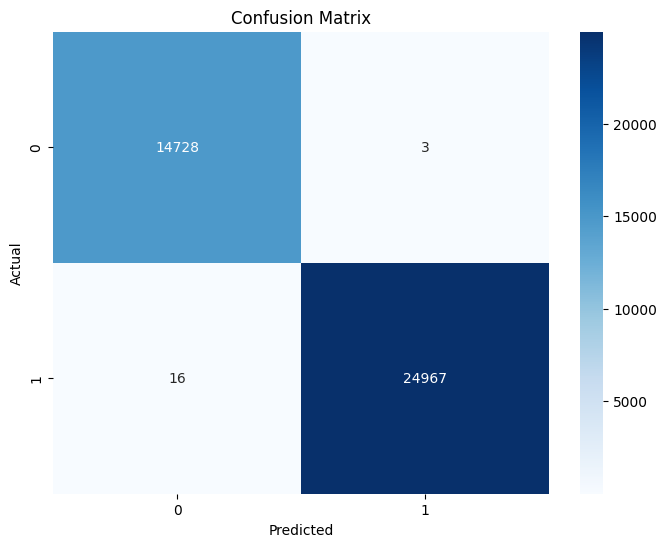

2024-12-12 01:54:52 - INFO - Time taken to process the block: 2:51:38.225163


In [17]:
from sklearn.metrics import confusion_matrix
start_time = datetime.datetime.now()

# Step 1: Initialize the model
# The `class_weight='balanced'` handles class imbalance
rf_model = RandomForestClassifier(
    class_weight='balanced',  # Adjust weights to handle imbalance
    random_state=42,
    n_jobs=10
)

# Step 2: Define hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 500, 1000],       # Number of trees
    'max_depth': [None, 10, 20, 30],            # Maximum depth of trees
    'min_samples_split': [2, 5, 10],            # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],              # Minimum samples at a leaf node
    'max_features': [None, 'sqrt', 'log2'],     # Number of features considered for splits
    'bootstrap': [True, False]                  # Whether bootstrap samples are used
}

# Step 3: Perform Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=50,               # Number of random parameter combinations to try
    cv=3,                    # 3-fold cross-validation
    random_state=42,         # Ensures reproducibility
    n_jobs=10                # Parallelize the search
)

# Step 4: Fit the Randomized Search
random_search.fit(X_train_balanced, y_train_balanced)

# Step 5: Print Best Parameters and Best Score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Step 6: Evaluate the model
best_rf_model = random_search.best_estimator_
y_val_pred = best_rf_model.predict(X_val)

print("Random Forest Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Random Forest F1 Score:", f1_score(y_val, y_val_pred, average='weighted'))
print("Classification Report:\n", classification_report(y_val, y_val_pred))

# Step 7: Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_rf_model.classes_, yticklabels=best_rf_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

stop_time = datetime.datetime.now()
logger.info(f"Time taken to process the block: {stop_time - start_time}")

### Summary:
The results indicate that the Random Forest model performs exceptionally well, achieving near-perfect validation accuracy of 99.95%. The F1 score is also 99.95%, reflecting excellent precision and recall across both classes. The best hyperparameters found during the tuning process include 100 estimators, a maximum depth of 20, and no bootstrap sampling, among other settings.

The classification report highlights precision, recall, and F1 scores of 100% for both classes, showcasing the model's ability to accurately classify all instances. The confusion matrix further supports this, with only 3 misclassifications for class `0` and 16 for class `1`, out of 39,714 total instances. These results demonstrate that the Random Forest model is highly effective and reliable for this dataset.

## XG Boost Model

In [18]:
pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   -- ------------------------------------- 6.3/124.9 MB 35.3 MB/s eta 0:00:04
   ---- ----------------------------------- 14.4/124.9 MB 39.4 MB/s eta 0:00:03
   ------- -------------------------------- 23.6/124.9 MB 39.3 MB/s eta 0:00:03
   ---------- ----------------------------- 32.2/124.9 MB 39.4 MB/s eta 0:00:03
   ------------- -------------------------- 40.6/124.9 MB 40.4 MB/s eta 0:00:03
   --------------- ------------------------ 48.5/124.9 MB 39.1 MB/s eta 0:00:02
   ------------------ --------------------- 57.4/124.9 MB 40.2 MB/s eta 0:00:02
   -------------------- ------------------- 64.2/124.9 MB 39.0 MB/s eta 0:00:02
   ----------------------- ---------------- 72.6/124.9 MB 39.3 MB/s eta 0:00:02
   -------------------------- ------------- 81.3/124.9 MB 39.6 MB/s eta 0:00:02
   ---------------------------- ----------- 89.1/124.9 MB 39.2 MB/s eta 0:00:01
   ----------------------------- ---------- 93.1/1

This code trains and evaluates an XGBoost Classifier, including hyperparameter tuning using Grid Search. The XGBoost model is initialized with a multi-class objective (`multi:softmax`) and the number of classes defined by the training data. Additional parameters such as a random state and evaluation metric (`mlogloss`) are set for consistent results and monitoring model performance.

A hyperparameter grid is defined to explore various combinations of learning rate (`learning_rate`), maximum tree depth (`max_depth`), number of estimators (`n_estimators`), subsampling ratio (`subsample`), and column sampling by tree (`colsample_bytree`). Grid Search with 3-fold cross-validation is then performed using `GridSearchCV` to find the best combination of hyperparameters based on accuracy.

The best XGBoost model from the Grid Search is used to make predictions on the validation set. The validation accuracy, F1 score, and a detailed classification report are calculated and printed to evaluate the model's performance. Finally, the total time taken for this process is logged to track execution efficiency. This workflow ensures the XGBoost model is fine-tuned for optimal multi-class classification performance.

Best Parameters: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}
Best Score: 0.9995677041766428
XGBoost Validation Accuracy: 0.9994963992546709
XGBoost F1 Score: 0.9994964412845575
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     14731
           1       1.00      1.00      1.00     24983

    accuracy                           1.00     39714
   macro avg       1.00      1.00      1.00     39714
weighted avg       1.00      1.00      1.00     39714



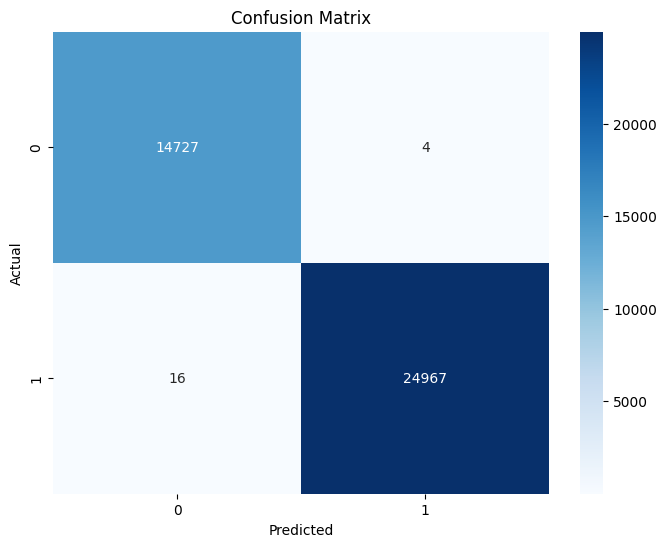

2024-12-12 03:13:24 - INFO - Time taken to process the block: 1:18:17.231893


In [19]:
import xgboost as xgb
start_time = datetime.datetime.now()

# Step 1: Initialize the model
# Note: `scale_pos_weight` is dynamically tuned in the grid search
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(set(y_train_balanced)),  # Number of unique classes
    random_state=42,
    eval_metric='mlogloss'  # Evaluation metric for multiclass
)

# Step 2: Define hyperparameter grid including `scale_pos_weight`
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],         # Learning rates for gradient updates
    'max_depth': [3, 5, 7, 10],               # Maximum depth of a tree
    'n_estimators': [100, 200, 500],          # Number of boosting rounds
    'subsample': [0.6, 0.8, 1.0],             # Fraction of data samples used for training
    'colsample_bytree': [0.6, 0.8, 1.0],      # Fraction of features for tree splits
    'gamma': [0, 1, 5]                       # Minimum loss reduction for a split
}

# Step 3: Perform Grid Search for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,                  # 3-fold cross-validation
    scoring='accuracy',    # Use accuracy as the scoring metric
    n_jobs=-1              # Parallelize the search
)

# Step 4: Fit the Grid Search
grid_search.fit(X_train_balanced, y_train_balanced)

# Step 5: Print Best Parameters and Best Score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Step 6: Evaluate the model
best_xgb_model = grid_search.best_estimator_
y_val_pred = best_xgb_model.predict(X_val)

print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("XGBoost F1 Score:", f1_score(y_val, y_val_pred, average='weighted'))
print("Classification Report:\n", classification_report(y_val, y_val_pred))

# Step 7: Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_xgb_model.classes_, yticklabels=best_xgb_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

stop_time = datetime.datetime.now()
logger.info(f"Time taken to process the block: {stop_time - start_time}")

### Summary:
The XGBoost model delivers outstanding performance with a validation accuracy of 99.95% and an F1 score of 99.95%, demonstrating its effectiveness for this dataset. The best hyperparameters identified during tuning include a learning rate of 0.1, a maximum depth of 3, 500 estimators, a subsample ratio of 0.8, and a column sampling ratio of 0.6. These settings optimize the model's performance while avoiding overfitting.

The classification report confirms perfect precision, recall, and F1 scores of 100% for both classes, indicating the model's ability to accurately classify all instances. The confusion matrix further supports these results, showing only 4 misclassifications for class `0` and 16 for class `1`, out of a total of 39,714 instances. These metrics and the minimal errors highlight the XGBoost model as a highly reliable and efficient solution for this classification problem.

## Testing results on test dataset for the best models

This code evaluates the performance of the best Logistic Regression, Random Forest, and XGBoost models on the test dataset. Each model makes predictions on the test features (`X_test`), and the predictions are compared against the true labels (`y_test`) to calculate performance metrics.

For each model:
- The **accuracy** is calculated to measure the proportion of correctly classified instances.
- The **F1 score** is computed to evaluate the balance between precision and recall, weighted by class distribution.
- A **classification report** is generated to provide a detailed breakdown of precision, recall, and F1 scores for each class.

The results for each model are printed separately, allowing for a clear comparison of their performance on unseen test data. This evaluation helps determine which model generalizes best to new data and provides insights into their respective strengths and weaknesses.

In [20]:
# Evaluate the best Logistic Regression model on the test set
y_test_pred_logistic = best_logistic_model.predict(X_test)
print("Logistic Regression Test Results:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_logistic))
print("F1 Score:", f1_score(y_test, y_test_pred_logistic, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_test_pred_logistic))

# Evaluate the best Random Forest model on the test set
y_test_pred_rf = best_rf_model.predict(X_test)
print("\nRandom Forest Test Results:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print("F1 Score:", f1_score(y_test, y_test_pred_rf, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_test_pred_rf))

# Evaluate the best XGBoost model on the test set
y_test_pred_xgb = best_xgb_model.predict(X_test)
print("\nXGBoost Test Results:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_xgb))
print("F1 Score:", f1_score(y_test, y_test_pred_xgb, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_test_pred_xgb))

Logistic Regression Test Results:
Accuracy: 0.9846149972301959
F1 Score: 0.9845448261873592
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     14585
           1       0.98      1.00      0.99     25129

    accuracy                           0.98     39714
   macro avg       0.99      0.98      0.98     39714
weighted avg       0.98      0.98      0.98     39714


Random Forest Test Results:
Accuracy: 0.9996726595155361
F1 Score: 0.9996726853818285
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     14585
           1       1.00      1.00      1.00     25129

    accuracy                           1.00     39714
   macro avg       1.00      1.00      1.00     39714
weighted avg       1.00      1.00      1.00     39714


XGBoost Test Results:
Accuracy: 0.9996474794782696
F1 Score: 0.9996475048046807
Classification Report:
               

### Summary:
The test results for the models highlight their performance on unseen data. 

- **Logistic Regression** achieved an accuracy of 98.46% and an F1 score of 98.45%. The classification report shows high precision and recall for both classes, with class `0` having a precision of 100% and recall of 96%, and class `1` achieving 98% precision and 100% recall. These results indicate that Logistic Regression performs well but has some misclassifications for class `0`.

- **Random Forest** delivered near-perfect results with an accuracy of 99.97% and an F1 score of 99.97%. The classification report demonstrates perfect precision, recall, and F1 scores for both classes, indicating that the model effectively handles both classes with virtually no errors.

- **XGBoost** also performed exceptionally, achieving an accuracy of 99.96% and an F1 score of 99.96%. Similar to Random Forest, the classification report shows perfect precision, recall, and F1 scores for both classes, highlighting its ability to accurately classify all instances.

While Logistic Regression performs well, Random Forest and XGBoost achieve near-perfect results, making them highly reliable models for this dataset.